In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install --quiet scvi-colab
from scvi_colab import install
install()

/home/mo/miniconda3/envs/ivelo/lib/python3.8/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import torch
import scarches as sca
import matplotlib.pyplot as plt
import seaborn as sns
import argparse
from velovi import VELOVI

 captum (see https://github.com/pytorch/captum).
INFO:lightning_lite.utilities.seed:Global seed set to 0


In [4]:
#Choose dataset
dataset = "pancreas"

#Choose model to train
model = "divelo"

if dataset == "pbmc":
    cell_column = 'celltype'
elif dataset == "pancreas":
    cell_column = 'clusters'
elif dataset == "dentategyrus":
    cell_column = 'clusters'
elif dataset == "hindbrain":
    cell_column = 'Celltype'

metrics_dict = "output/" + dataset + "/" + model + "/latent_analysis.pkl"

In [5]:
adata_file = "data/" + dataset + "/" + dataset + "_data_annotations.h5ad"
adata_output = "data/" + dataset + "/" + model + "/data_output.h5ad" #path of output adata after training model
adata = sc.read(adata_file)

In [6]:
#Load model
vae=VELOVI.load("trained_models/" + dataset + "/" + model, adata)

INFO     File trained_models/pancreas/divelo/model.pt already downloaded                                           
Last Decoder layer: softmax


Add outputs of velo_interpret to adata

In [7]:
def add_velovi_outputs_to_adata(adata, vae):
    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time

    adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    adata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0

add_velovi_outputs_to_adata(adata, vae)

### Velocity comparison

Compare model to velovi

In [17]:
#Compute MSE

import pandas as pd
pred=vae.get_expression_fit()
pred_s=pred[0]
pred_u=pred[1]
GT_s=adata.layers["Ms"]
GT_u=adata.layers["Mu"]
MSE_s=np.mean((pred_s-GT_s)**2, axis=0)
MSE_u=np.mean((pred_u-GT_u)**2, axis=0)

MSE=pd.DataFrame([MSE_s,MSE_u]).T

MSE.to_csv("output/" + dataset + "/" + model + "/" + "MSE_.csv")


In [8]:
#calculate velocity confidence
scv.tl.velocity_graph(adata, n_jobs=10)
scv.tl.velocity_confidence(adata)
vel_conf=adata.obs["velocity_confidence"]

computing velocity graph (using 10/12 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


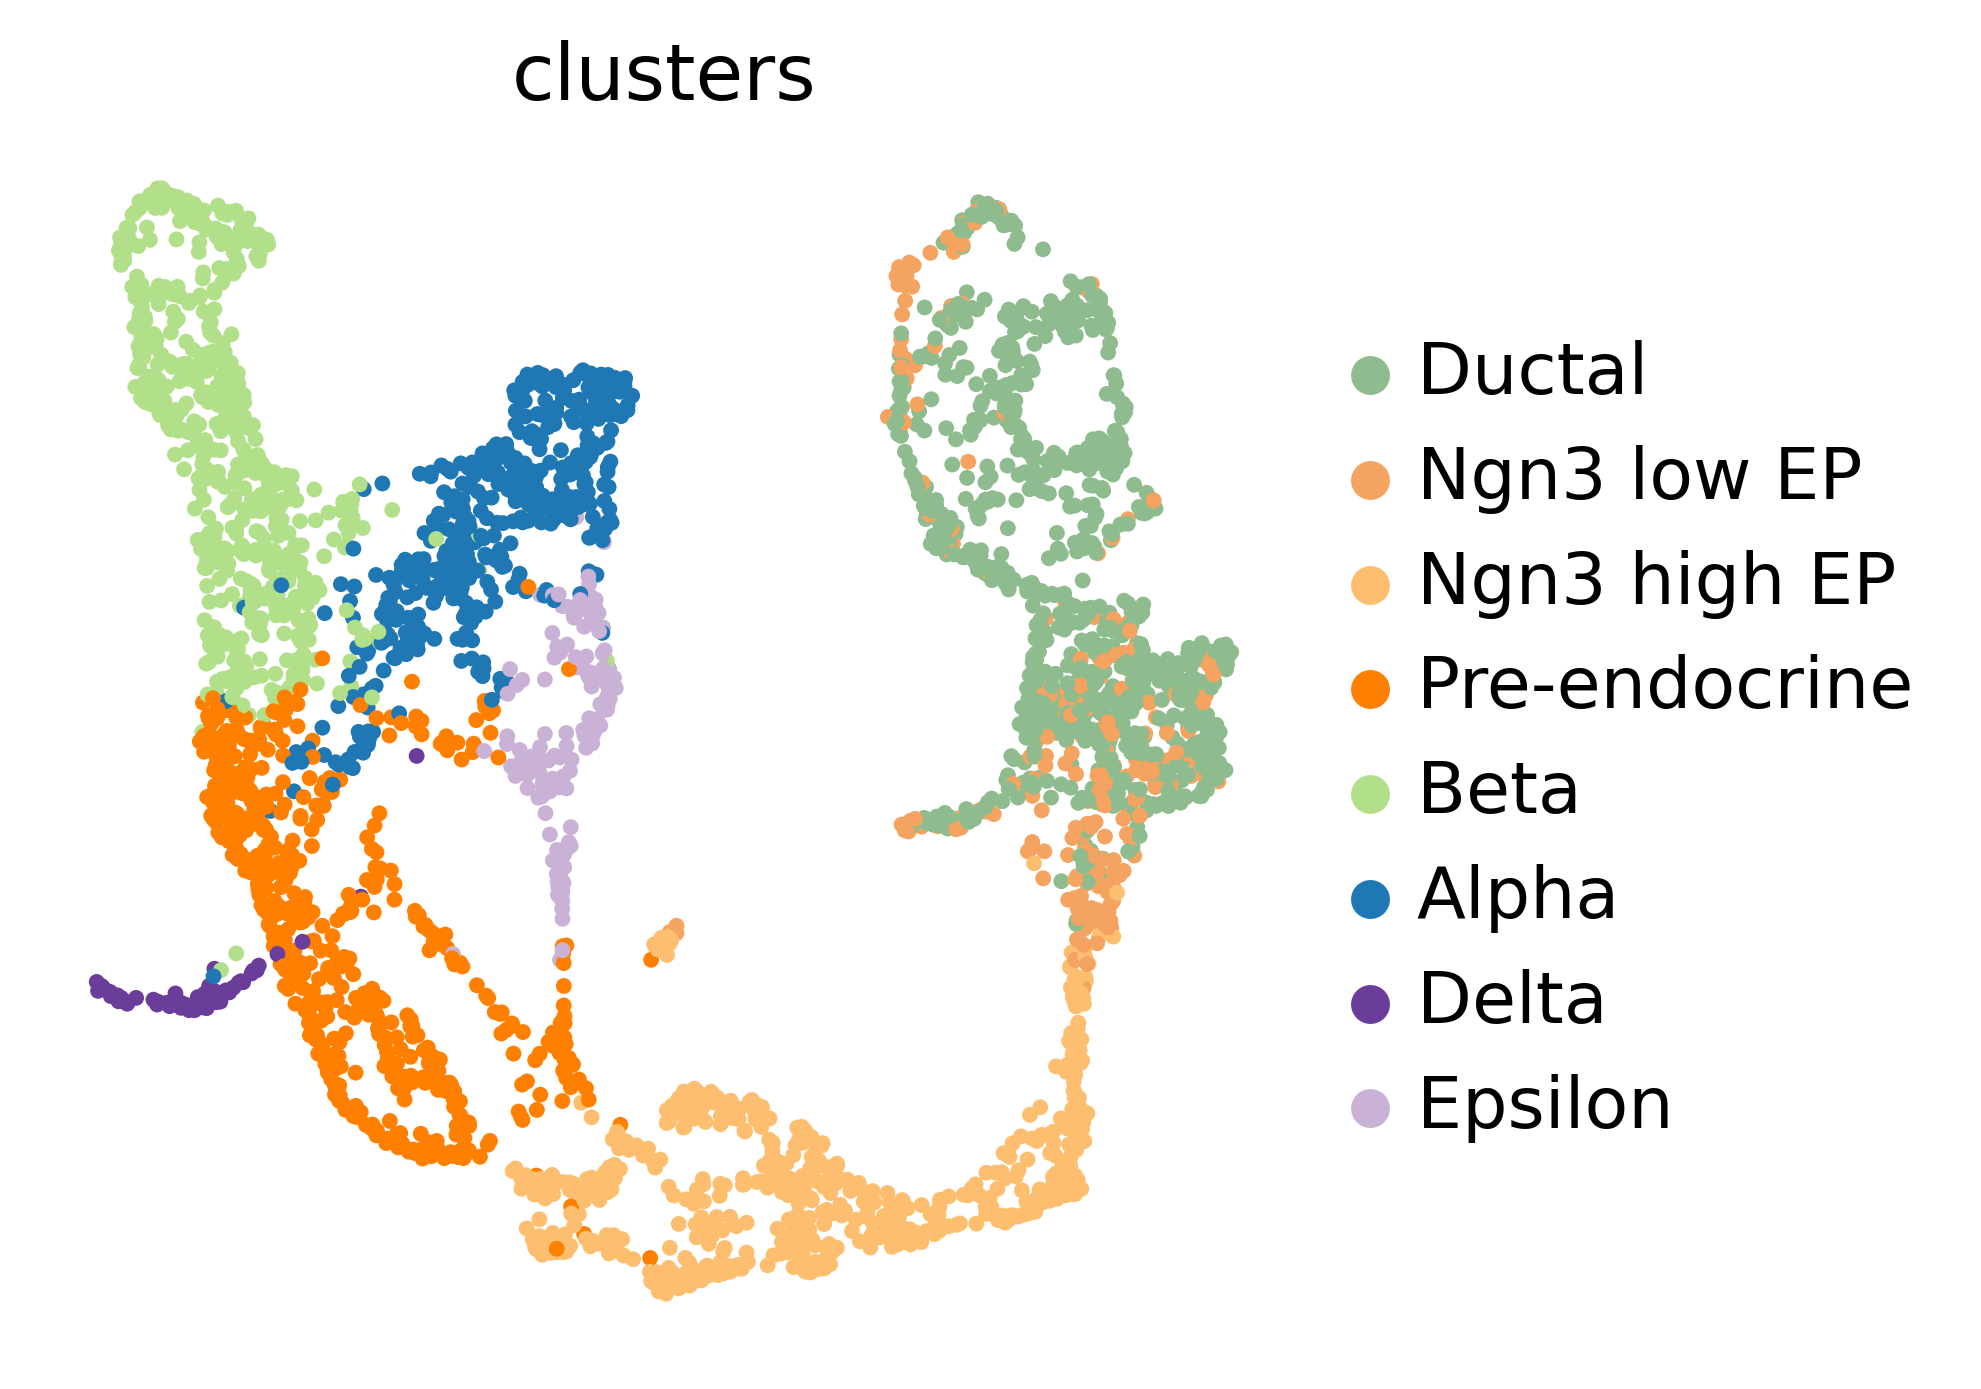

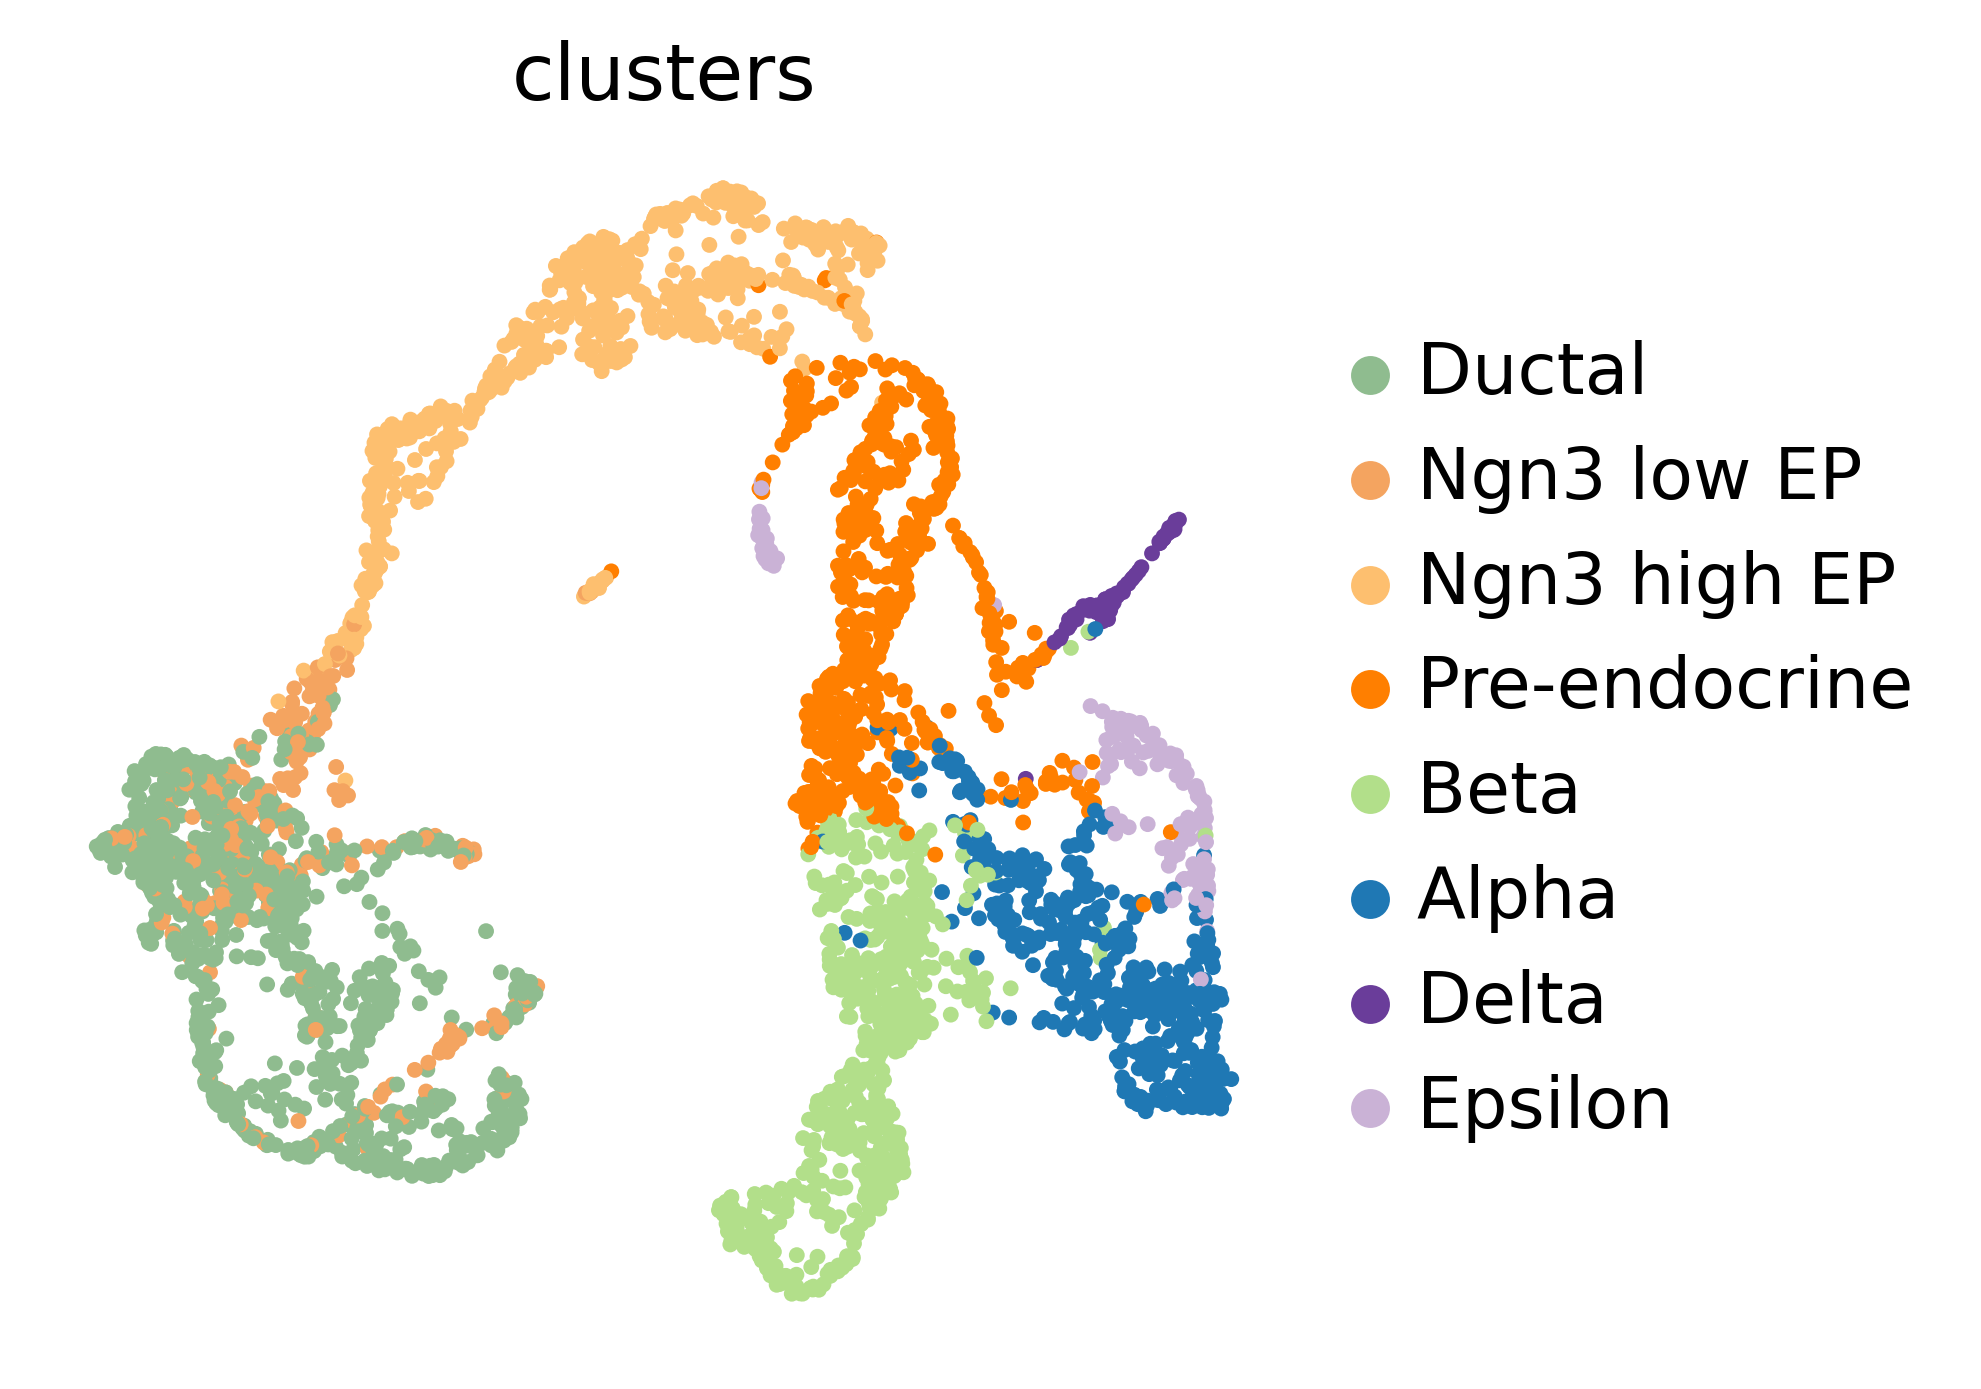

In [18]:
adata.obsm["X_" + model + "_opt_all"] = vae.get_latent()
adata.obsm["X_" + model + "_opt_active"] = vae.get_latent(only_active=True)

sc.pp.neighbors(adata, use_rep="X_" + model + "_opt_all")
sc.tl.umap(adata)
sc.pl.umap(adata, color=cell_column, frameon=False, save="_" + model + "_opt_all.png")

sc.pp.neighbors(adata, use_rep="X_" + model + "_opt_active")
sc.tl.umap(adata)
sc.pl.umap(adata, color=cell_column, frameon=False, save="_" + model + "_opt_active.png")

In [26]:
adata

AnnData object with n_obs × n_vars = 2930 × 244
    obs: 'clusters', 'age(days)', 'clusters_enlarged', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'velocity_length', 'velocity_confidence', 'velocity_confidence_transition', 'cluster'
    var: 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'clusters_colors', 'leiden', 'neighbors', 'pca', 'terms', 'umap', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_divelo_opt_active', 'X_divelo_opt_all', 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'I', 'PCs'
    layers: 'Ms', 'Mu', 'ambiguous', 'latent_time_velovi', 'spliced', 'unspliced', 'velocity', 'fit_t'
    obsp: 'connectivities', 'distances'

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_vel_embedding_pancreasdivelo.png


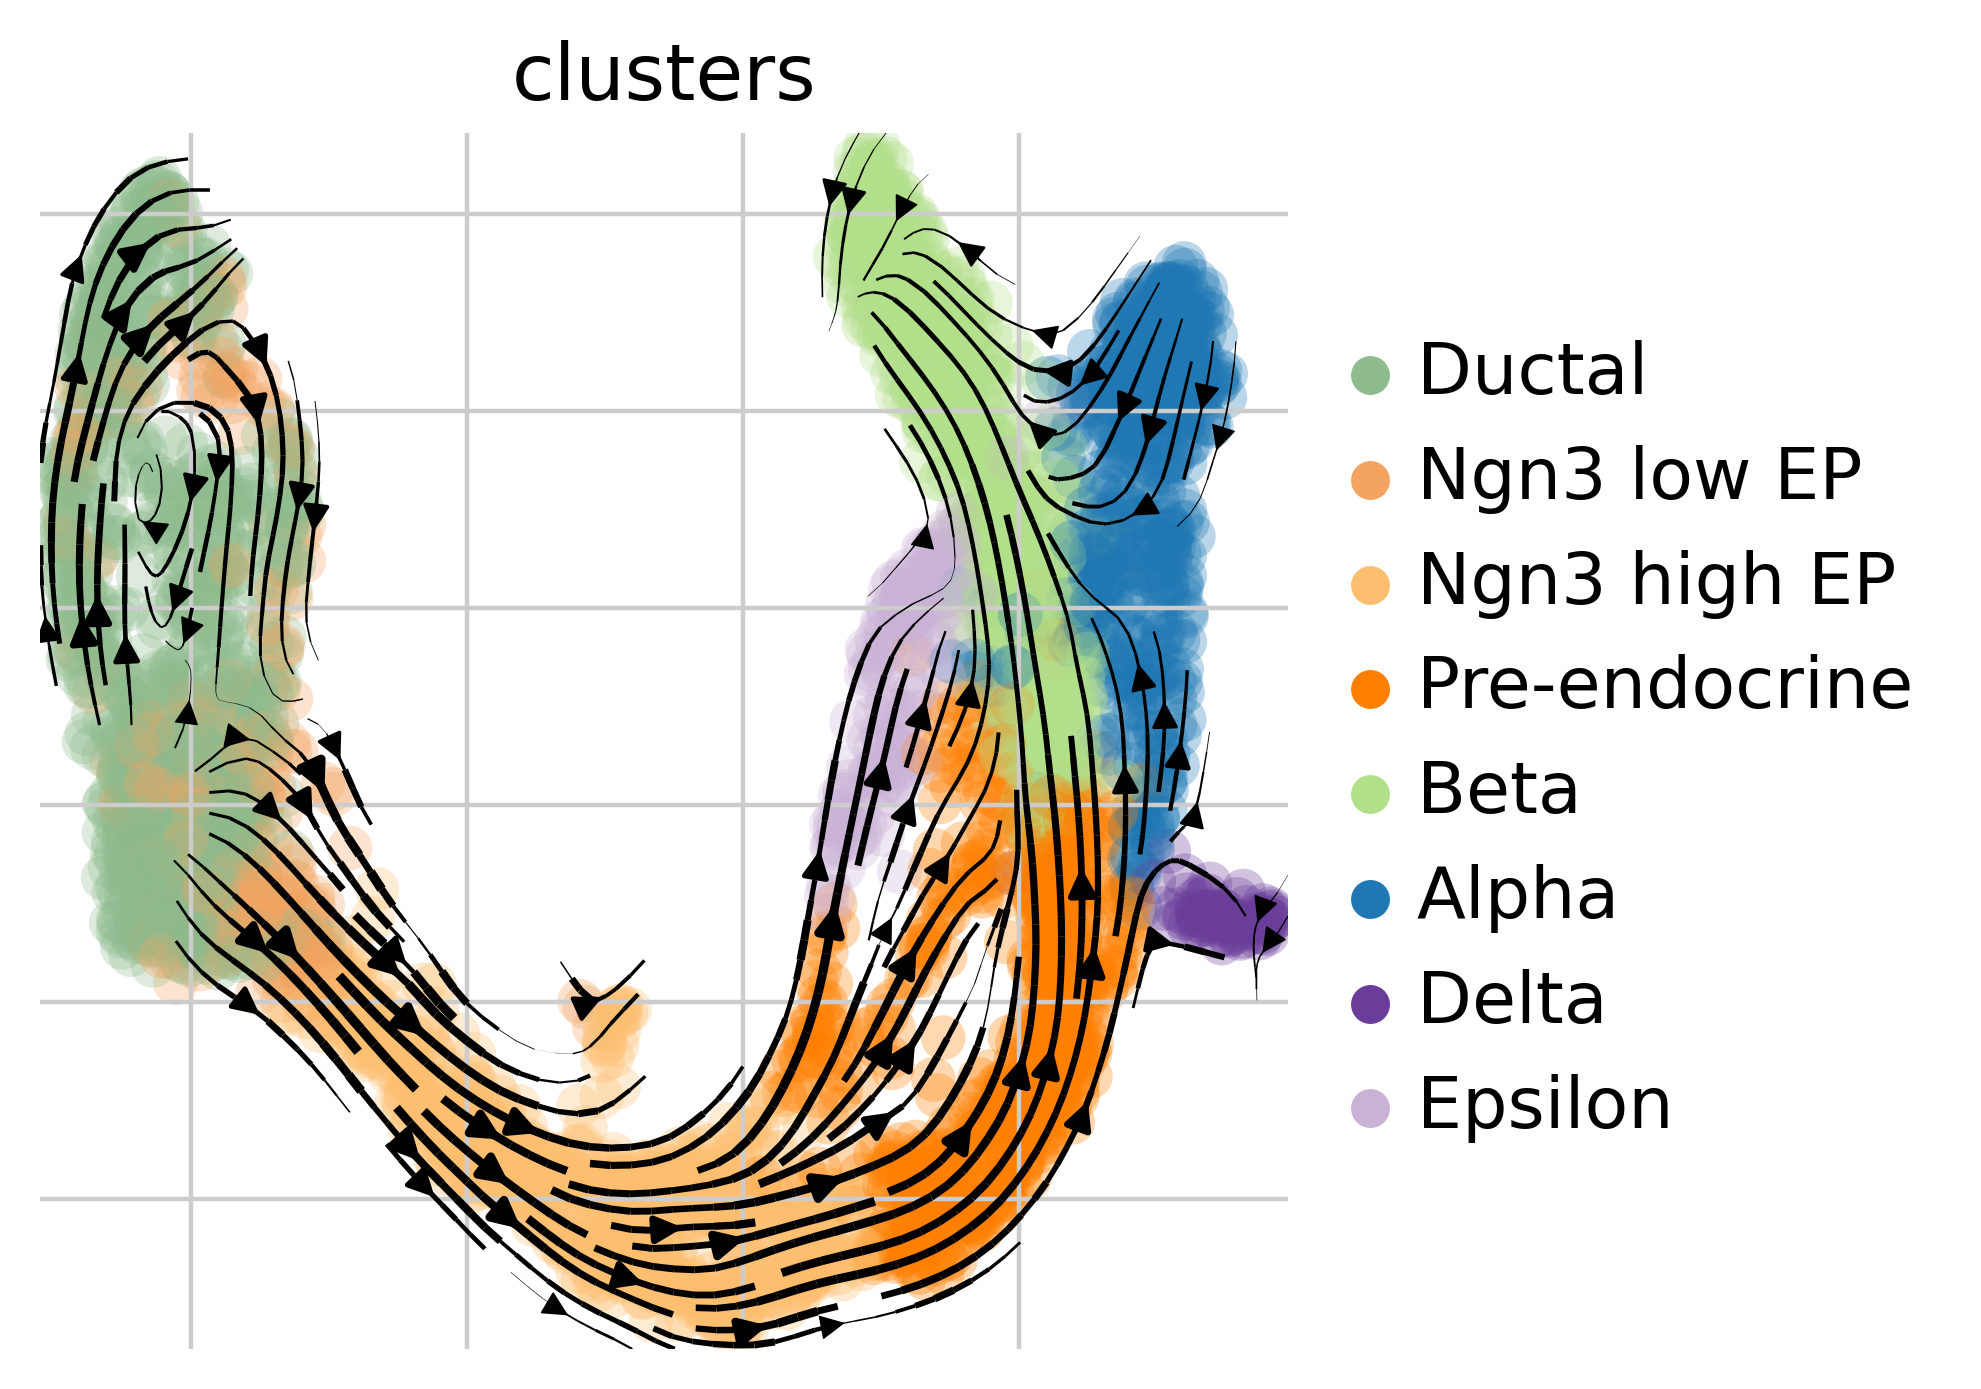

In [9]:
scv.pl.velocity_embedding_stream(adata, basis='umap', color=cell_column, legend_loc="right margin", save="vel_embedding_" + dataset + model + ".png")

In [15]:
import scib

scib.metrics.cluster_optimal_resolution(adata, cluster_key="cluster", label_key=cell_column)
print(f"vel_conf: {np.mean(vel_conf)}")
print(f"nmi: {scib.metrics.nmi(adata, group1='cluster', group2=cell_column)}")
print(f"ari: {scib.me.ari(adata, group1='cluster', group2=cell_column)}")
print(f"asw: {scib.me.silhouette(adata, group_key=cell_column, embed='X_' + model + '_opt_active')}")
print(f"cluster avg: {(scib.metrics.nmi(adata, group1='cluster', group2=cell_column)+scib.me.ari(adata, group1='cluster', group2=cell_column)+scib.me.silhouette(adata, group_key=cell_column, embed='X_' + model + '_opt_active'))/3}")
print(f"metrics avg: {(np.mean(vel_conf)+scib.metrics.nmi(adata, group1='cluster', group2=cell_column)+scib.me.ari(adata, group1='cluster', group2=cell_column)+scib.me.silhouette(adata, group_key=cell_column, embed='X_' + model + '_opt_active'))/4}")

resolution: 0.1, nmi: 0.6465681827463645
resolution: 0.2, nmi: 0.614106924842242
resolution: 0.3, nmi: 0.5687675132450715
resolution: 0.4, nmi: 0.5473721931644397
resolution: 0.5, nmi: 0.5396173183673846
resolution: 0.6, nmi: 0.525130641969327
resolution: 0.7, nmi: 0.518931420643893
resolution: 0.8, nmi: 0.49869716536759806
resolution: 0.9, nmi: 0.5011210351885426
resolution: 1.0, nmi: 0.49485005747166627
resolution: 1.1, nmi: 0.4907792239906822
resolution: 1.2, nmi: 0.4919986309735024
resolution: 1.3, nmi: 0.4873310938266057
resolution: 1.4, nmi: 0.4803564592427027
resolution: 1.5, nmi: 0.4850491577775094
resolution: 1.6, nmi: 0.4840634269283122
resolution: 1.7, nmi: 0.47672886759083427
resolution: 1.8, nmi: 0.48224083212789065
resolution: 1.9, nmi: 0.47628312936471595
resolution: 2.0, nmi: 0.4764781590493367
optimised clustering against Celltype
optimal cluster resolution: 0.1
optimal score: 0.6465681827463645
vel_conf: 0.9141633427414168
nmi: 0.6465681827463645
ari: 0.68437273907985

/tmp/ipykernel_27942/4029711944.py:5: DeprecationWarning: Keyword argument 'group1' has been deprecated in favour of 'cluster_key'. 'group1' will be removed in a future version.
  print(f"nmi: {scib.metrics.nmi(adata, group1='cluster', group2=cell_column)}")
/tmp/ipykernel_27942/4029711944.py:5: DeprecationWarning: Keyword argument 'group2' has been deprecated in favour of 'label_key'. 'group2' will be removed in a future version.
  print(f"nmi: {scib.metrics.nmi(adata, group1='cluster', group2=cell_column)}")
/tmp/ipykernel_27942/4029711944.py:6: DeprecationWarning: Keyword argument 'group1' has been deprecated in favour of 'cluster_key'. 'group1' will be removed in a future version.
  print(f"ari: {scib.me.ari(adata, group1='cluster', group2=cell_column)}")
/tmp/ipykernel_27942/4029711944.py:6: DeprecationWarning: Keyword argument 'group2' has been deprecated in favour of 'label_key'. 'group2' will be removed in a future version.
  print(f"ari: {scib.me.ari(adata, group1='cluster', g

asw: 0.5849602520465851


/tmp/ipykernel_27942/4029711944.py:8: DeprecationWarning: Keyword argument 'group1' has been deprecated in favour of 'cluster_key'. 'group1' will be removed in a future version.
  print(f"cluster avg: {(scib.metrics.nmi(adata, group1='cluster', group2=cell_column)+scib.me.ari(adata, group1='cluster', group2=cell_column)+scib.me.silhouette(adata, group_key=cell_column, embed='X_' + model + '_opt_active'))/3}")
/tmp/ipykernel_27942/4029711944.py:8: DeprecationWarning: Keyword argument 'group2' has been deprecated in favour of 'label_key'. 'group2' will be removed in a future version.
  print(f"cluster avg: {(scib.metrics.nmi(adata, group1='cluster', group2=cell_column)+scib.me.ari(adata, group1='cluster', group2=cell_column)+scib.me.silhouette(adata, group_key=cell_column, embed='X_' + model + '_opt_active'))/3}")
/tmp/ipykernel_27942/4029711944.py:8: DeprecationWarning: Keyword argument 'group1' has been deprecated in favour of 'cluster_key'. 'group1' will be removed in a future version

cluster avg: 0.6386337246242688


/tmp/ipykernel_27942/4029711944.py:9: DeprecationWarning: Keyword argument 'group1' has been deprecated in favour of 'cluster_key'. 'group1' will be removed in a future version.
  print(f"metrics avg: {(np.mean(vel_conf)+scib.metrics.nmi(adata, group1='cluster', group2=cell_column)+scib.me.ari(adata, group1='cluster', group2=cell_column)+scib.me.silhouette(adata, group_key=cell_column, embed='X_' + model + '_opt_active'))/4}")
/tmp/ipykernel_27942/4029711944.py:9: DeprecationWarning: Keyword argument 'group2' has been deprecated in favour of 'label_key'. 'group2' will be removed in a future version.
  print(f"metrics avg: {(np.mean(vel_conf)+scib.metrics.nmi(adata, group1='cluster', group2=cell_column)+scib.me.ari(adata, group1='cluster', group2=cell_column)+scib.me.silhouette(adata, group_key=cell_column, embed='X_' + model + '_opt_active'))/4}")
/tmp/ipykernel_27942/4029711944.py:9: DeprecationWarning: Keyword argument 'group1' has been deprecated in favour of 'cluster_key'. 'group1'

metrics avg: 0.7075161291535559


In [19]:
#make dictionary of metrics for plotting
import scib

scib.metrics.cluster_optimal_resolution(adata, cluster_key="cluster", label_key=cell_column)
metrics={}
metrics["vel_conf"] = np.mean(adata.obs["velocity_confidence"])
metrics["nmi"] = scib.me.nmi(adata, group1="cluster", group2=cell_column)
metrics["ari"] = scib.me.ari(adata, group1="cluster", group2=cell_column)
metrics["asw"] = scib.me.silhouette(adata, group_key=cell_column, embed="X_" + model + "_opt_all")
metrics["clust_avg"] = (scib.metrics.nmi(adata, group1="cluster", group2=cell_column)+scib.me.ari(adata, group1="cluster", group2=cell_column)+scib.me.silhouette(adata, group_key=cell_column, embed="X_" + model + "_opt_all"))/3,
metrics["metrics_avg"] = (np.mean(adata.obs["velocity_confidence"])+scib.metrics.nmi(adata, group1="cluster", group2=cell_column)+scib.me.ari(adata, group1="cluster", group2=cell_column)+scib.me.silhouette(adata, group_key=cell_column, embed="X_" + model + "_opt_active"))/4

resolution: 0.1, nmi: 0.7295501909305185
resolution: 0.2, nmi: 0.7183391388219735
resolution: 0.3, nmi: 0.686575657630433
resolution: 0.4, nmi: 0.6672017082728944
resolution: 0.5, nmi: 0.6543522498978855
resolution: 0.6, nmi: 0.6456964677692701
resolution: 0.7, nmi: 0.6398454107352362
resolution: 0.8, nmi: 0.6399361931642784
resolution: 0.9, nmi: 0.6245812704670767
resolution: 1.0, nmi: 0.6168792924104015
resolution: 1.1, nmi: 0.6052638154094262
resolution: 1.2, nmi: 0.6196359161790506
resolution: 1.3, nmi: 0.6113502773003278
resolution: 1.4, nmi: 0.6030783435731281
resolution: 1.5, nmi: 0.5951828665393081
resolution: 1.6, nmi: 0.593765940472754
resolution: 1.7, nmi: 0.5863426895141838
resolution: 1.8, nmi: 0.5790724116452847
resolution: 1.9, nmi: 0.5831615029638016
resolution: 2.0, nmi: 0.5847174080494089
optimised clustering against clusters
optimal cluster resolution: 0.1
optimal score: 0.7295501909305185


/tmp/ipykernel_31428/1108104835.py:7: DeprecationWarning: Keyword argument 'group1' has been deprecated in favour of 'cluster_key'. 'group1' will be removed in a future version.
  metrics["nmi"] = scib.me.nmi(adata, group1="cluster", group2=cell_column)
/tmp/ipykernel_31428/1108104835.py:7: DeprecationWarning: Keyword argument 'group2' has been deprecated in favour of 'label_key'. 'group2' will be removed in a future version.
  metrics["nmi"] = scib.me.nmi(adata, group1="cluster", group2=cell_column)
/tmp/ipykernel_31428/1108104835.py:8: DeprecationWarning: Keyword argument 'group1' has been deprecated in favour of 'cluster_key'. 'group1' will be removed in a future version.
  metrics["ari"] = scib.me.ari(adata, group1="cluster", group2=cell_column)
/tmp/ipykernel_31428/1108104835.py:8: DeprecationWarning: Keyword argument 'group2' has been deprecated in favour of 'label_key'. 'group2' will be removed in a future version.
  metrics["ari"] = scib.me.ari(adata, group1="cluster", group2=c

In [20]:
#save dictionary to pkl
import pickle
with open(metrics_dict, 'wb') as f:
    pickle.dump(metrics, f)

In [24]:
metrics

{'vel_conf': 0.8987406909433536,
 'nmi': 0.7295501909305186,
 'ari': 0.6342208398743878,
 'asw': 0.6008566841483116,
 'clust_avg': (0.6548759049844061,),
 'metrics_avg': 0.7158480004713306}

In [23]:
adata.write(adata_output)

Uncertainty

In [10]:
uncertainty_df, _ = vae.get_directional_uncertainty(n_samples=100)
uncertainty_df.head()

INFO     velovi: Sampling from model...                                                                            
INFO     velovi: Computing the uncertainties...                                                                    


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.5s
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:   10.6s
Global seed set to 0
Global seed set to 0
Global seed set to 0
[Parallel(n_jobs=-1)]: Done 2190 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 3696 out of 3696 | elapsed:   15.3s finished


directional_variance  directional_difference  \
index                                                            
AAACCTGAGAGGGATA              0.002349                0.157432   
AAACCTGAGCCTTGAT              0.002779                0.176232   
AAACCTGAGGCAATTA              0.001854                0.136700   
AAACCTGCATCATCCC              0.003199                0.181276   
AAACCTGGTAAGTGGC              0.002365                0.160582   

                  directional_cosine_sim_variance  \
index                                               
AAACCTGAGAGGGATA                         0.001456   
AAACCTGAGCCTTGAT                         0.001743   
AAACCTGAGGCAATTA                         0.001106   
AAACCTGCATCATCCC                         0.001793   
AAACCTGGTAAGTGGC                         0.001395   

                  directional_cosine_sim_difference  \
index                                                 
AAACCTGAGAGGGATA                           0.122950   
AAACCTGAGCCTTGAT                           0.140265   
AAACCTGAGGCAATTA                           0.105755   
AAACCTGCATCATCCC                           0.135359   
AAACCTGGTAAGTGGC                           0.122531   

                  directional_cosine_sim_mean  
index                                          
AAACCTGAGAGGGATA                     0.618331  
AAACCTGAGCCTTGAT                     0.608632  
AAACCTGAGGCAATTA                     0.634823  
AAACCTGCATCATCCC                     0.660304  
AAACCTGGTAAGTGGC                     0.644233

In [11]:
for c in uncertainty_df.columns:
    adata.obs[c] = np.log10(uncertainty_df[c].values)

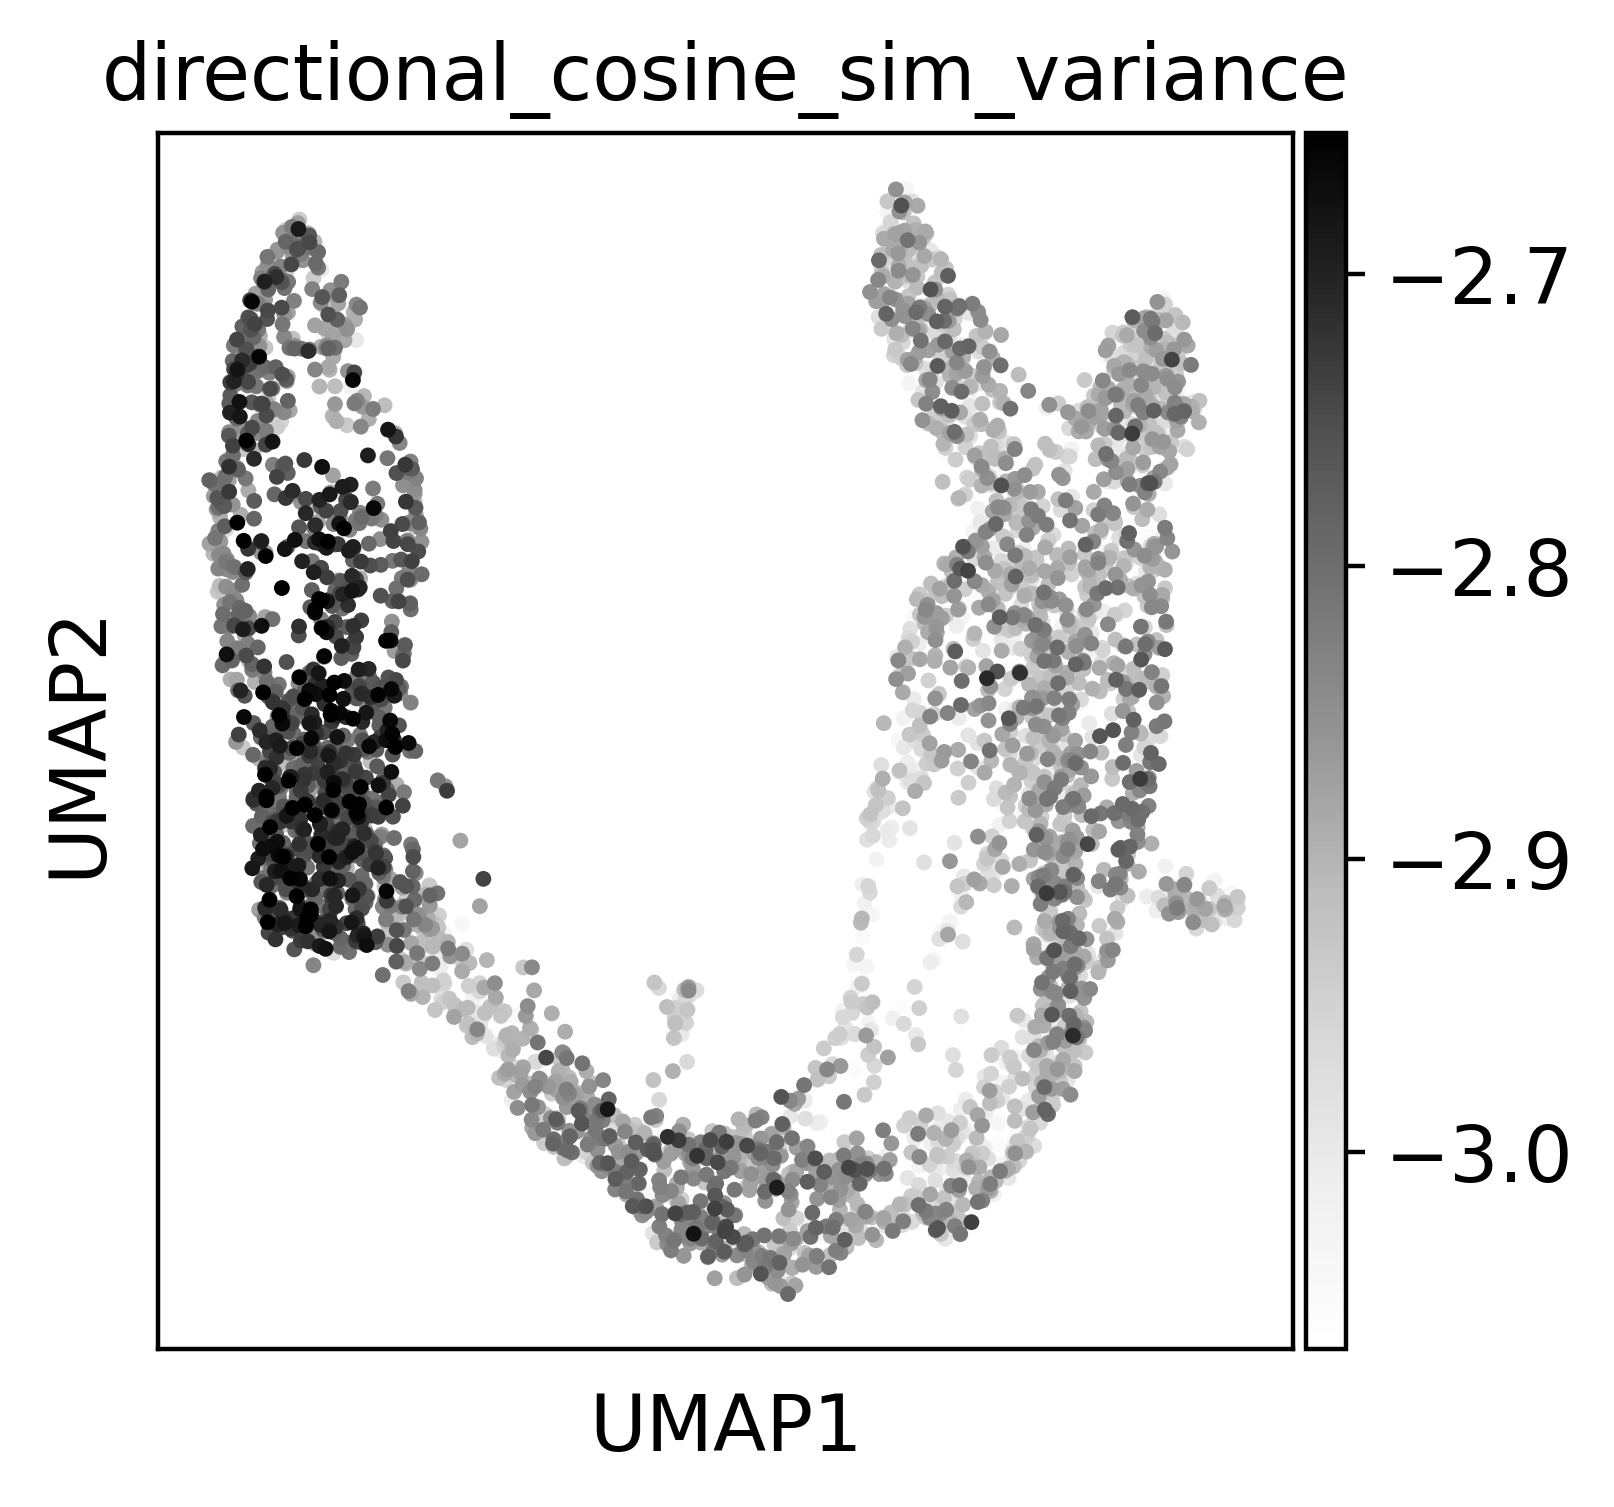

In [12]:
sc.pl.umap(
    adata, 
    color="directional_cosine_sim_variance",
    cmap="Greys",
    vmin="p1",
    vmax="p99",
)

### Extrinsic uncertainty

In [13]:
def compute_extrinisic_uncertainty(adata, vae, n_samples=25) -> pd.DataFrame:
    from velovi._model import _compute_directional_statistics_tensor
    from scvi.utils import track
    from contextlib import redirect_stdout
    import io

    extrapolated_cells_list = []
    for i in track(range(n_samples)):
        with io.StringIO() as buf, redirect_stdout(buf):
            vkey = "velocities_velovi_{i}".format(i=i)
            v = vae.get_velocity(n_samples=1, velo_statistic="mean")
            adata.layers[vkey] = v
            scv.tl.velocity_graph(adata, vkey=vkey, sqrt_transform=False, approx=True)
            t_mat = scv.utils.get_transition_matrix(
                adata, vkey=vkey, self_transitions=True, use_negative_cosines=True
            )
            extrapolated_cells = np.asarray(t_mat @ adata.layers["Ms"])
            extrapolated_cells_list.append(extrapolated_cells)
    extrapolated_cells = np.stack(extrapolated_cells_list)
    df, _ = _compute_directional_statistics_tensor(extrapolated_cells, n_jobs=-1, n_cells=adata.n_obs)
    return df

In [14]:
ext_uncertainty_df = compute_extrinisic_uncertainty(adata, vae)

Working...:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:   4%|▍         | 1/25 [00:01<00:37,  1.54s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:   8%|▊         | 2/25 [00:03<00:36,  1.57s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  12%|█▏        | 3/25 [00:04<00:35,  1.62s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  16%|█▌        | 4/25 [00:06<00:34,  1.63s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  20%|██        | 5/25 [00:08<00:32,  1.60s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  24%|██▍       | 6/25 [00:09<00:30,  1.62s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  28%|██▊       | 7/25 [00:11<00:29,  1.62s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  32%|███▏      | 8/25 [00:12<00:27,  1.64s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  36%|███▌      | 9/25 [00:14<00:26,  1.63s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  40%|████      | 10/25 [00:16<00:24,  1.65s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  44%|████▍     | 11/25 [00:17<00:23,  1.66s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  48%|████▊     | 12/25 [00:19<00:21,  1.66s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  52%|█████▏    | 13/25 [00:21<00:20,  1.68s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  56%|█████▌    | 14/25 [00:23<00:18,  1.69s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  60%|██████    | 15/25 [00:24<00:16,  1.69s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  64%|██████▍   | 16/25 [00:26<00:15,  1.68s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  68%|██████▊   | 17/25 [00:28<00:13,  1.67s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  72%|███████▏  | 18/25 [00:29<00:11,  1.66s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  76%|███████▌  | 19/25 [00:31<00:09,  1.65s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  80%|████████  | 20/25 [00:33<00:08,  1.68s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  84%|████████▍ | 21/25 [00:34<00:06,  1.68s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  88%|████████▊ | 22/25 [00:36<00:05,  1.69s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  92%|█████████▏| 23/25 [00:38<00:03,  1.70s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  96%|█████████▌| 24/25 [00:39<00:01,  1.68s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...: 100%|██████████| 25/25 [00:41<00:00,  1.66s/it]
INFO     velovi: Computing the uncertainties...                                                                    


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3528 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3673 out of 3696 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 3696 out of 3696 | elapsed:    1.1s finished


In [15]:
for c in ext_uncertainty_df.columns:
    adata.obs[c + "_extrinisic"] = np.log10(ext_uncertainty_df[c].values)

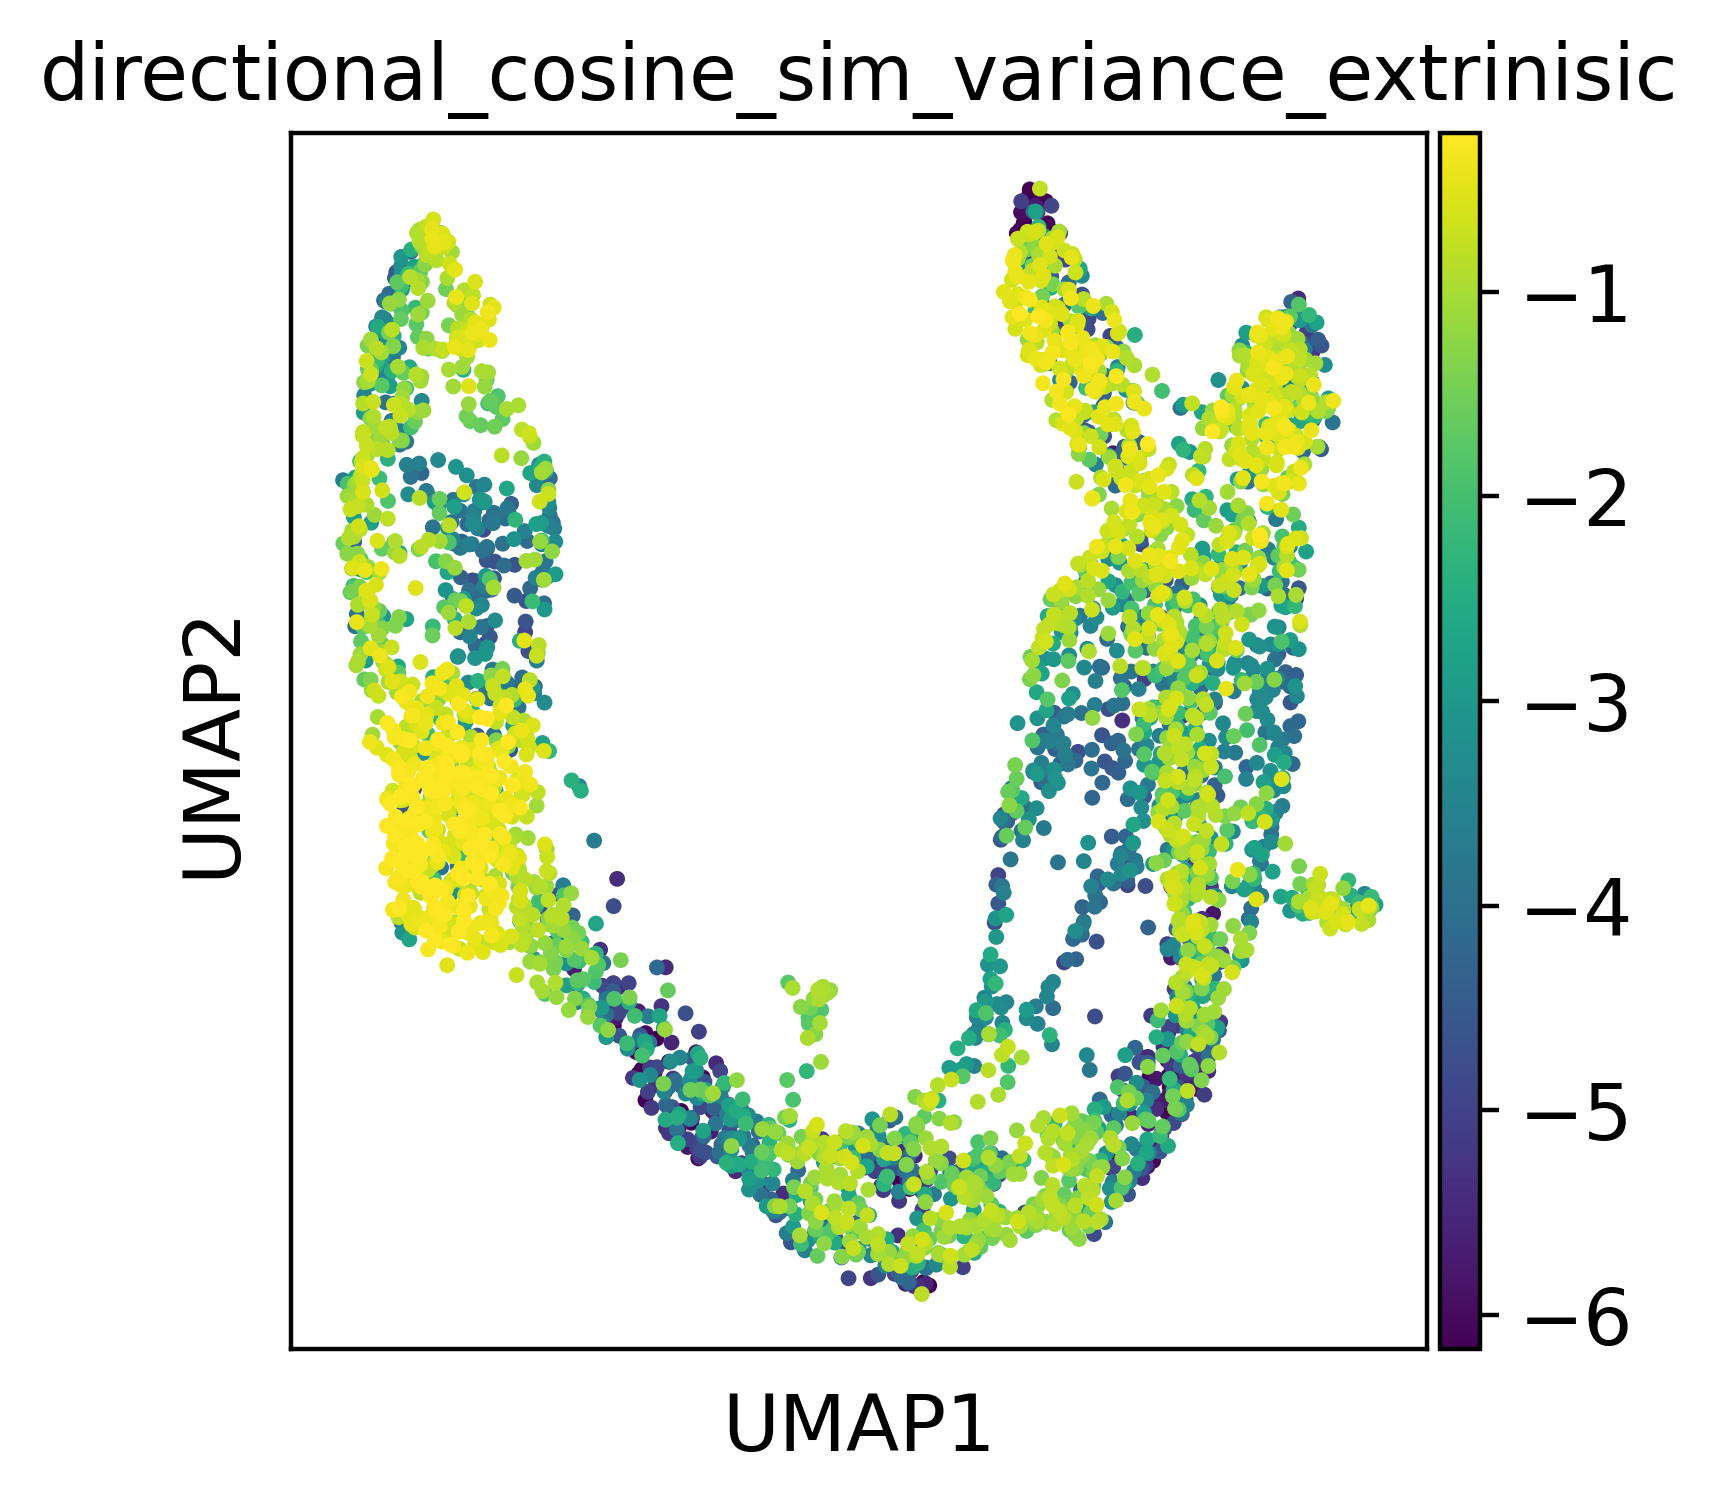

In [16]:
sc.pl.umap(
    adata, 
    color="directional_cosine_sim_variance_extrinisic",
    vmin="p1", 
    vmax="p99", 
)

Latent enrichment

In [25]:
from itertools import compress
vae.latent_directions(adata=adata)
active_terms_idx=list(compress(np.arange(len(adata.uns["terms"])), vae.nonzero_terms()))
scores_ct = vae.latent_enrich(cell_column, use_directions=True, select_terms = active_terms_idx, adata=adata, exact=True)

/home/mo/miniconda3/envs/ivelo/lib/python3.8/site-packages/anndata-0.8.0-py3.8.egg/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['velocity_graph'] that happens to be dimensioned at n_obs×n_obs (3696×3696).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/mo/miniconda3/envs/ivelo/lib/python3.8/site-packages/anndata-0.8.0-py3.8.egg/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['velocity_graph_neg'] that happens to be dimensioned at n_obs×n_obs (3696×3696).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/mo/miniconda3/envs/ivelo/lib/python3.8/site-packages/anndata-0.8.0-py3.8.egg/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['velocities_velovi_0_graph'] that happens to be dimensioned at n_obs×n_

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/mo/miniconda3/envs/ivelo/lib/python3.8/site-packages/anndata-0.8.0-py3.8.egg/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                         

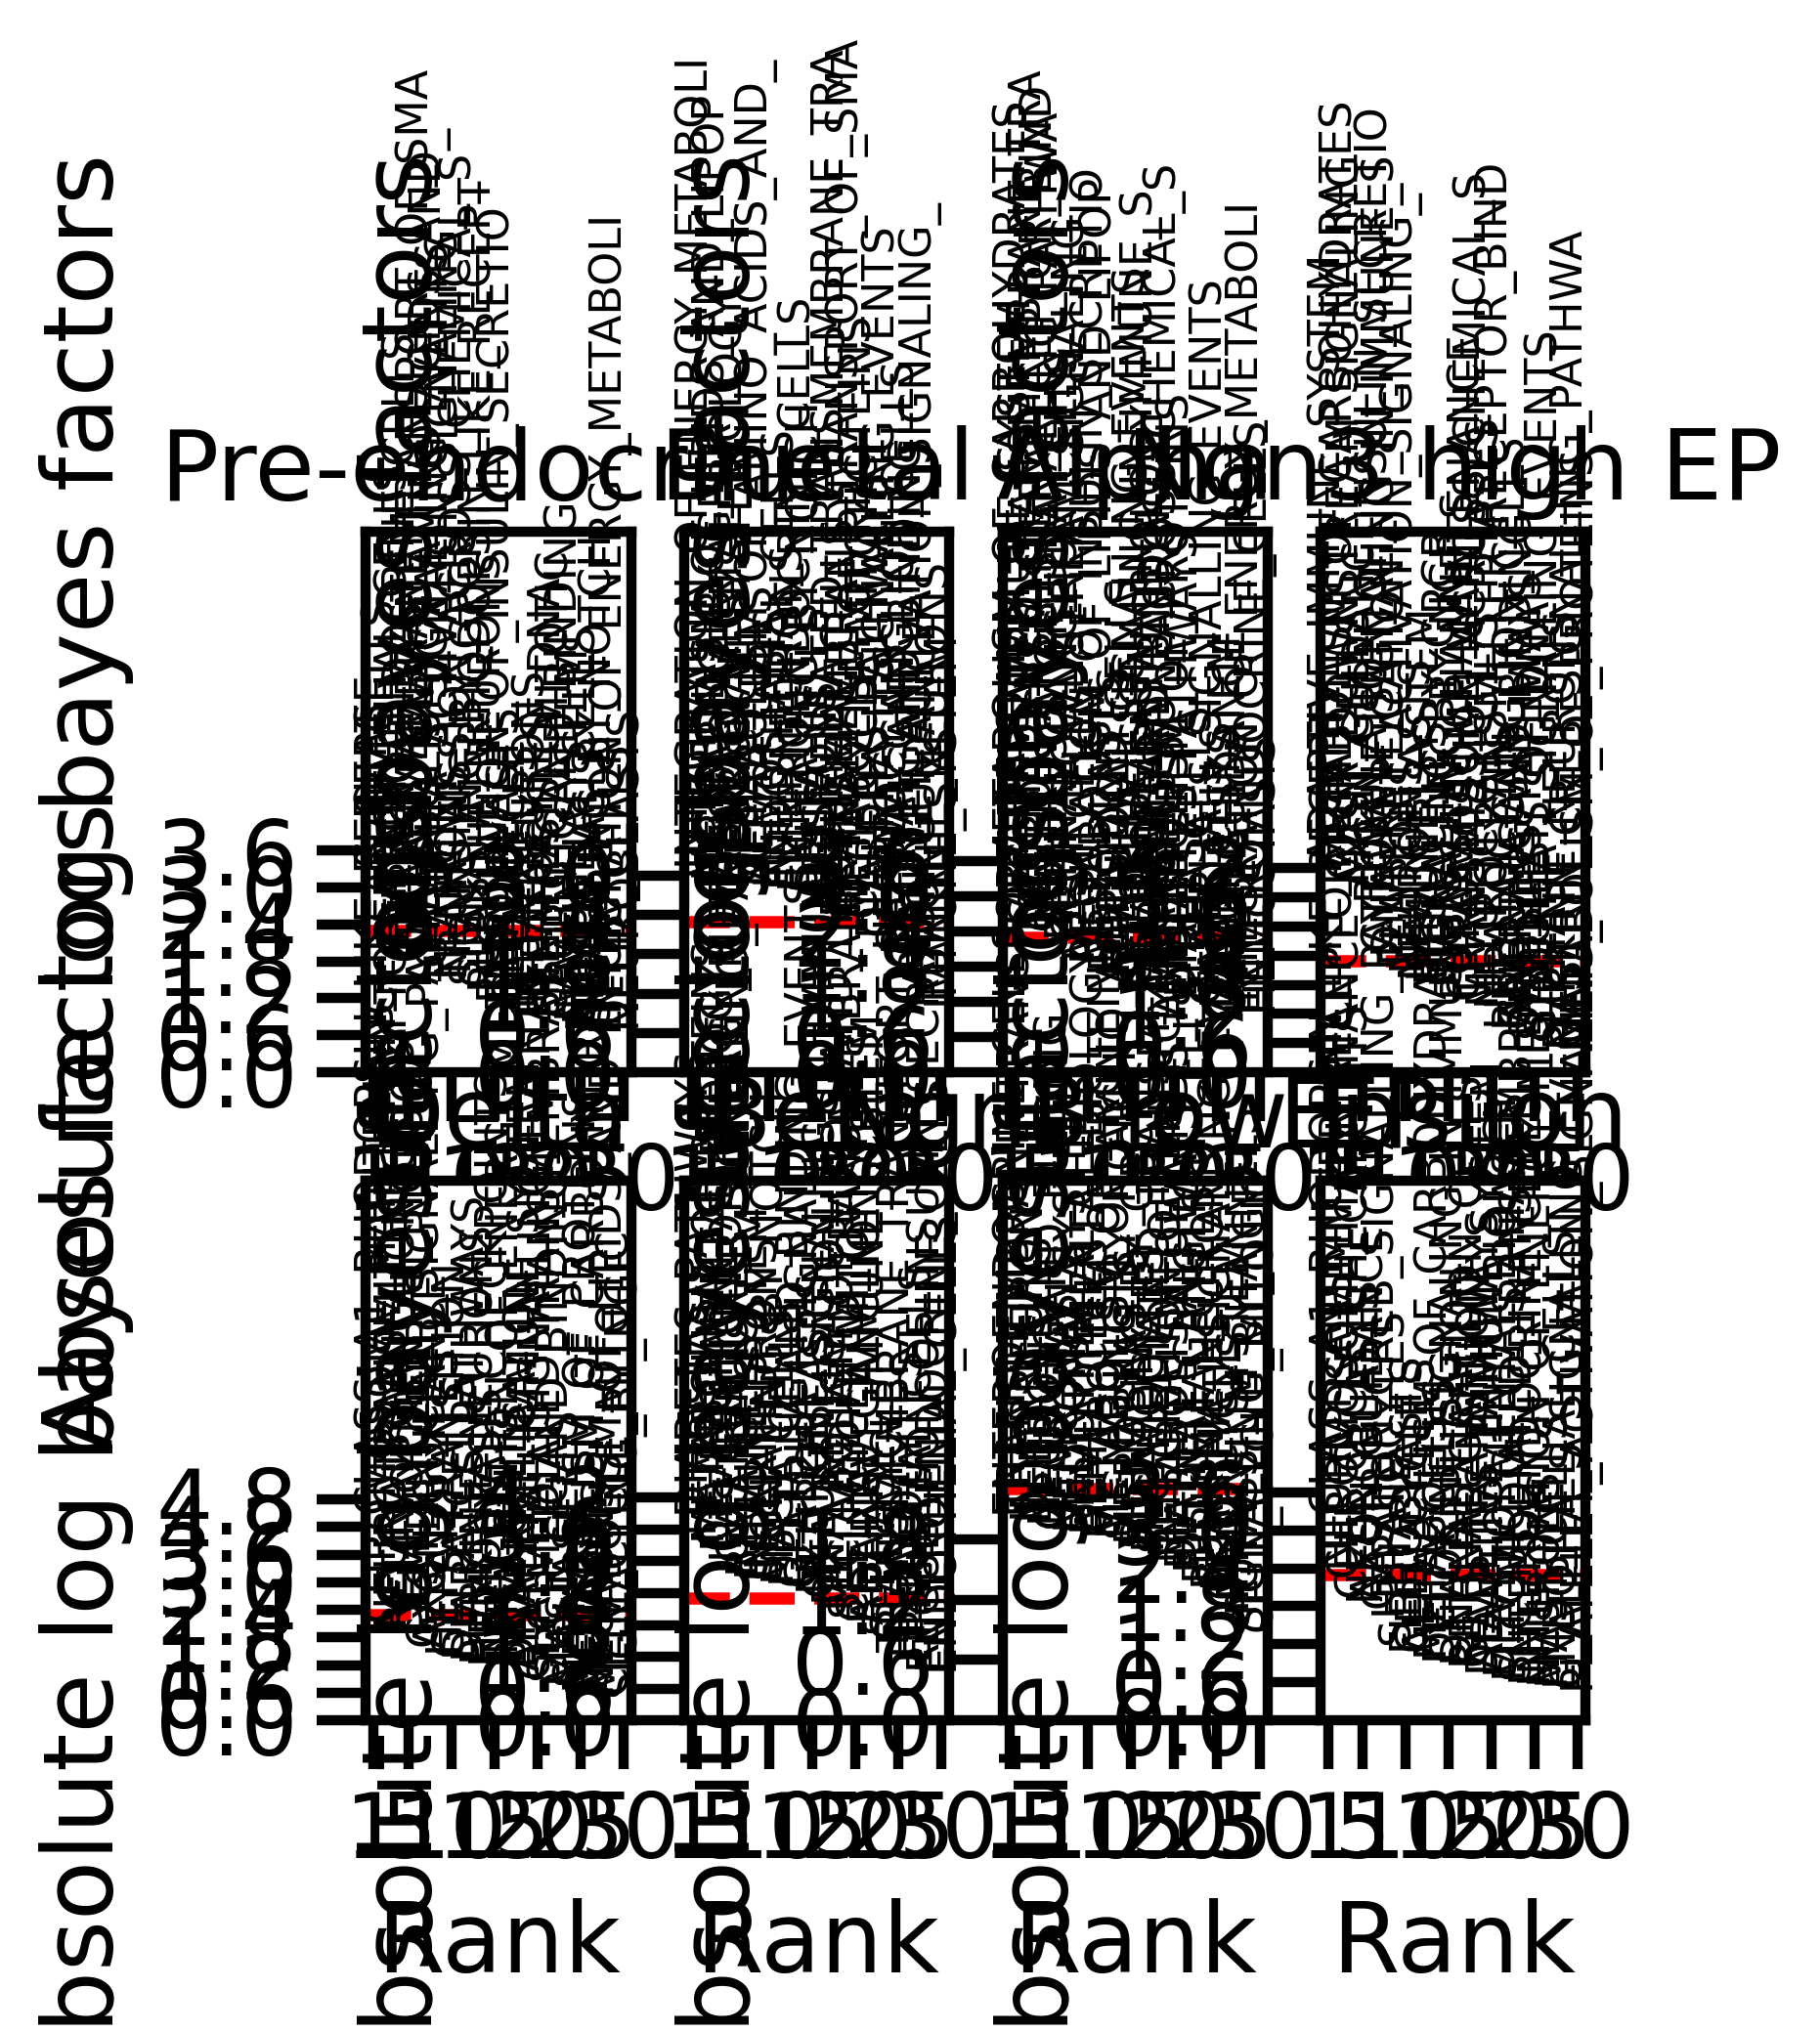

In [26]:
active_terms=list(compress(adata.uns["terms"], vae.nonzero_terms()))
fig = sca.plotting.plot_abs_bfs(adata, n_cols=4, terms=active_terms, scale_y=2.6, yt_step=0.6)

In [27]:
fig.set_size_inches(24, 20)
fig

In [28]:
fig.savefig("figures/" + dataset + "/" + model + "/latent_enrich.png")

### Save latent enrich results to dictionary

In [29]:
import collections
top_gps_per_cell = collections.defaultdict(dict)
for cell_type in adata.uns["bf_scores"].keys():
    mask=abs(adata.uns["bf_scores"][cell_type]["bf"])>=2.3
    GP_index=np.arange(len(active_terms))
    sig_GP_index=list(compress(GP_index, mask))
    top_gps_per_cell[cell_type]["terms"] = np.array(active_terms)[sig_GP_index]
    top_gps_per_cell[cell_type]["terms"] = np.array(active_terms)[sig_GP_index]
    top_gps_per_cell[cell_type]["bf_scores"] = adata.uns["bf_scores"][cell_type]["bf"]
    top_gps_per_cell[cell_type]["bf_scores_sig"] = adata.uns["bf_scores"][cell_type]["bf"][mask]
    top_gps_per_cell[cell_type]["sig_GP_index"] = sig_GP_index

In [30]:
import collections

#add active terms and bf_scores into df

top_n_terms=[]
for cell_type in adata.uns["bf_scores"].keys():
    bf_scores=adata.uns["bf_scores"][cell_type]["bf"]
    d = {'active_terms': active_terms, 'bf_scores': bf_scores}
    df=pd.DataFrame(data=d, columns=["active_terms", "bf_scores"])
    top_n_df=df.sort_values(by=["bf_scores"], ascending=False)[:10]
    top_n_terms.extend(top_n_df["active_terms"])

top_n_terms = list(set(top_n_terms)) #100

In [31]:
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

idx = [active_terms.index(term) for term in top_n_terms]
directions=adata.uns["directions"]
directions=directions[directions!=0]
latents = (adata.obsm["X_" + model + "_opt_active"]*directions)[:, idx]
labels=pd.Categorical(adata.obs[cell_column]).codes
#for i in range(latents.shape[1]):
#    X_train, X_test, y_train, y_test = train_test_split(latents[:,i].reshape(-1, 1), labels, test_size=.2)
#    clf = GradientBoostingClassifier().fit(latents[:,i].reshape(-1, 1), labels)
#    pred=clf.predict(latents[:,i].reshape(-1, 1))
#    acc.append(clf.score(latents[:,i].reshape(-1, 1), labels))

X_train, X_test, y_train, y_test = train_test_split(latents, labels, test_size=0.2)
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

Do parameter tuning for XGBoost

In [ ]:
def fit(x):
    params = {'objective':'multi:softmax',
              'num_class': len(list(set(labels))),
              'learning_rate':int(x[0]),
              #'colsample_bytree':int(x[1]),
              #'learning_rate':0.1,
              'min_child_weight':1,
              'max_depth':5,
             
             }
    xgb_cv = xgb.cv(dtrain=data_dmatrix, params=params, early_stopping_rounds=50,
    nfold=5, seed=42)
    return xgb_cv[-1:].values[0]

grid = pd.DataFrame({'learning_rate':[0.01, 0.05, 0.1], 
                     #'colsample_bytree':np.repeat([0.6,0.7,0.8,0.9],4), 
                     #'min_child_weight':np.repeat([1,2,3],3)
                     #'learning_rate':np.repeat([0.01,0.05,0.1],3),
                     #'subsample':np.repeat([0.1,0.3],3)
                    })

grid[['train-mean','train-std',
'test-mean','test-std']] = grid.apply(fit,axis=1,result_type='expand')

In [ ]:
grid

Train and evaluate model with optimal parameters

In [32]:
clf = XGBClassifier(objective='multi:softmax',
                           learning_rate = 0.1,
                           min_child_weight = 1,
                           max_depth = 5,
                   
                   )

clf.fit(X_train, y_train)

preds = clf.predict(X_test)
accuracy = accuracy_score(y_test, preds)
print(accuracy)
top_gps_per_cell["XGB_acc"] = accuracy

0.9162162162162162


In [33]:
#save dictionary to pkl
import pickle
with open('output/' + dataset + '/' + model + '/GP_analysis.pkl', 'wb') as f:
    pickle.dump(top_gps_per_cell, f)